In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [30]:
dataset = pd.read_excel('data/data.xlsx')
empty_data = dataset.dropna(how='all')
empty_data = empty_data.dropna(axis=1,how='all')
empty_data = empty_data.drop([0])
empty_data = empty_data.reset_index()
empty_data = empty_data.drop(columns=['L,p','index'])
dataset = empty_data

In [31]:
#Set equal label type for sick people
for i, row in dataset.iterrows():
    label = row['label']
    if label == ' s':
        dataset.at[i,'label'] = 's'
    elif label == 'S':
        dataset.at[i,'label'] = 's'

In [32]:
sick = dataset[(dataset['label']=='s')]
obese = dataset[(dataset['label']=='o')]
healthy = dataset[(dataset['label']=='k')]

In [33]:
#For rows where there is no age or weight, put random age generated from normal distribution with mean age and standard deviation of age
for set in [sick, obese, healthy]:
    mean_age = set[['age']].mean()
    std_age = set[['age']].std()
    for i, row in set.iterrows():
        (weight, age) = row[['weight','age']]
        if  pd.isnull(age):
            new_age = np.random.normal(mean_age,std_age)
            set.at[i,'age'] = new_age
        if (age < 5) and (weight > 40):
            new_age = np.random.normal(mean_age,std_age)
            set.at[i,'age'] = new_age
  

In [34]:
obese.describe()

,age,weight,height,BMI,mean for age,SD populacji,Z score BMI,50 centyl BMI,stłuszczenie w %,zapalenie,...,EPA,C22:2n-6,C22:4n-6,C22:5n-6,C24:0,C24:1n-9,C22:5n-3,DHA,AA/DGLA,DGLA/LA
count,78.000000,60.000000,61.000000,61.000000,29.000000,28.000000,27.000000,27.000000,0.0,0.0,...,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,14.375720,81.689167,1.672344,28.689690,20.317586,2.650000,2.118041,19.711111,NaN,NaN,...,0.229615,0.349359,0.372949,0.708718,0.235385,0.778846,0.618590,2.071667,2.524582,0.144844
std,3.102923,19.643303,0.169951,3.496097,1.575125,0.324893,3.188732,1.588258,NaN,NaN,...,0.193535,0.092895,0.074539,0.239026,0.106071,0.215539,0.218357,0.347221,0.772456,0.030449
min,2.270000,25.000000,0.980000,18.670000,15.830000,1.510000,-8.868852,15.400000,NaN,NaN,...,0.090000,0.190000,0.220000,0.140000,0.100000,0.390000,0.320000,1.310000,1.160714,0.069312
25%,13.000000,73.750000,1.650000,26.030820,19.810000,2.500000,1.966616,19.400000,NaN,NaN,...,0.132500,0.280000,0.320000,0.470000,0.142500,0.612500,0.440000,1.915000,1.868529,0.123871
50%,14.873243,82.000000,1.720000,28.641291,20.790000,2.600000,2.539149,20.500000,NaN,NaN,...,0.170000,0.350000,0.370000,0.750000,0.210000,0.760000,0.570000,2.130000,2.494240,0.141317
75%,16.500000,92.675000,1.773500,31.050000,21.640000,2.787500,3.740889,20.700000,NaN,NaN,...,0.227500,0.407500,0.410000,0.890000,0.310000,0.925000,0.740000,2.315000,2.952756,0.159249
max,19.930804,127.300000,1.880000,38.857178,21.650000,3.300000,5.833074,21.500000,NaN,NaN,...,1.100000,0.560000,0.530000,1.100000,0.500000,1.380000,1.570000,2.690000,4.210526,0.234487


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [36]:
def predict_weight(set, loop=0, plots = False):
    set_to_predict = set[set['weight'].isnull()][['age', 'weight']].drop('weight', axis = 1)
    set_train = set[set['weight'].notnull()][['age', 'weight']]

    assert set.shape[0] == set_to_predict.shape[0] + set_train.shape[0]

    X = set_train.drop('weight', axis = 1)
    y = set_train['weight']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=515)

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_real = scaler.transform(set_to_predict)

    alphas = np.arange(0.001,10,0.01)
    ridge_cv_model = RidgeCV(alphas=alphas,scoring='neg_root_mean_squared_error',cv=4)
    ridge_cv_model.fit(X_train,y_train)

    test_predictions = ridge_cv_model.predict(X_test)

    MAE = mean_absolute_error(y_test,test_predictions)
    MSE = mean_squared_error(y_test,test_predictions)
    RMSE = np.sqrt(MSE)

    print(f'MAE: {MAE}\nRMSE: {RMSE}')

    real_predictions = ridge_cv_model.predict(X_real)

    set_to_predict = np.squeeze(set_to_predict)

    if plots:
        sns.scatterplot(x=set_to_predict, y=real_predictions)
        sns.scatterplot(data=set_train, x='age', y='weight')
        if loop == 0:
            plt.title('Sick')
        elif loop == 1:
            plt.title('Obese')
        elif loop == 2:
            plt.title('Healthy')
        plt.show()

    for i, row in set.iterrows():
        (weight, age) = row[['weight','age']]
        if  pd.isnull(weight):
            new_weight = ridge_cv_model.predict(scaler.transform(np.reshape(a = np.array(age),newshape = (1,-1))))
            #
            set.at[i,'weight'] = new_weight


In [37]:
loop = 0 
for set in [sick, obese, healthy]:
    predict_weight(set, loop, False)
    loop +=1

MAE: 17.511637204905398
RMSE: 20.260151869529288


c:\Users\Z6JDB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Z6JDB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Z6JDB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Z6JDB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Z6JDB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScal

MAE: 14.084670560391864
RMSE: 17.59258508248554


c:\Users\Z6JDB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Z6JDB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Z6JDB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Z6JDB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Z6JDB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScal

MAE: 10.77500859047701
RMSE: 11.623269469815153


c:\Users\Z6JDB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Z6JDB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Z6JDB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Z6JDB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Z6JDB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScal

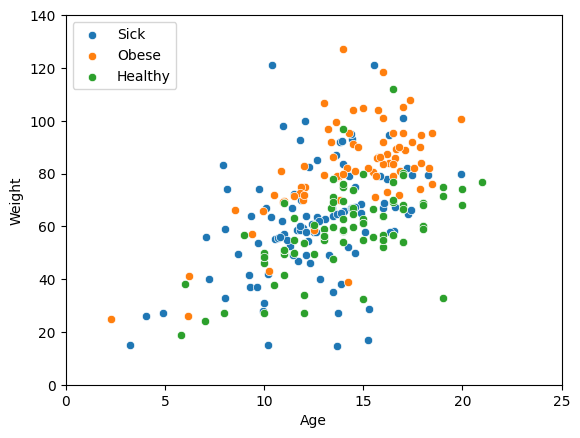

In [38]:

sns.scatterplot(data=sick, x = 'age', y='weight', label= 'Sick')
sns.scatterplot(data=obese, x = 'age', y='weight', label = 'Obese' )
sns.scatterplot(data=healthy, x = 'age', y='weight', label = 'Healthy')
plt.xlabel('Age')
plt.ylabel('Weight')
plt.ylim((0,140))
plt.xlim((0,25))
plt.legend(loc=2)

In [39]:
obese.describe()

,age,weight,height,BMI,mean for age,SD populacji,Z score BMI,50 centyl BMI,stłuszczenie w %,zapalenie,...,EPA,C22:2n-6,C22:4n-6,C22:5n-6,C24:0,C24:1n-9,C22:5n-3,DHA,AA/DGLA,DGLA/LA
count,78.000000,78.000000,61.000000,61.000000,29.000000,28.000000,27.000000,27.000000,0.0,0.0,...,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,14.375720,81.743063,1.672344,28.689690,20.317586,2.650000,2.118041,19.711111,NaN,NaN,...,0.229615,0.349359,0.372949,0.708718,0.235385,0.778846,0.618590,2.071667,2.524582,0.144844
std,3.102923,17.779891,0.169951,3.496097,1.575125,0.324893,3.188732,1.588258,NaN,NaN,...,0.193535,0.092895,0.074539,0.239026,0.106071,0.215539,0.218357,0.347221,0.772456,0.030449
min,2.270000,25.000000,0.980000,18.670000,15.830000,1.510000,-8.868852,15.400000,NaN,NaN,...,0.090000,0.190000,0.220000,0.140000,0.100000,0.390000,0.320000,1.310000,1.160714,0.069312
25%,13.000000,73.250000,1.650000,26.030820,19.810000,2.500000,1.966616,19.400000,NaN,NaN,...,0.132500,0.280000,0.320000,0.470000,0.142500,0.612500,0.440000,1.915000,1.868529,0.123871
50%,14.873243,82.000000,1.720000,28.641291,20.790000,2.600000,2.539149,20.500000,NaN,NaN,...,0.170000,0.350000,0.370000,0.750000,0.210000,0.760000,0.570000,2.130000,2.494240,0.141317
75%,16.500000,91.625705,1.773500,31.050000,21.640000,2.787500,3.740889,20.700000,NaN,NaN,...,0.227500,0.407500,0.410000,0.890000,0.310000,0.925000,0.740000,2.315000,2.952756,0.159249
max,19.930804,127.300000,1.880000,38.857178,21.650000,3.300000,5.833074,21.500000,NaN,NaN,...,1.100000,0.560000,0.530000,1.100000,0.500000,1.380000,1.570000,2.690000,4.210526,0.234487


In [40]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNetCV

In [41]:
def predict_height(set, loop, plots = False):
    
    set_to_predict = set[set['height'].isnull()][['age', 'weight', 'height']].drop('height', axis = 1)
    set_train = set[set['height'].notnull()][['age', 'weight', 'height']]

    assert set.shape[0] == set_to_predict.shape[0] + set_train.shape[0]
    
    X = set_train.drop(columns= 'height', axis = 1)
    y = set_train['height']
    polyniomial_transformer = PolynomialFeatures(degree=2, include_bias=False)
    polyniomial_transformer = polyniomial_transformer.fit(X)
    polynomial_features = polyniomial_transformer.transform(X)
    set_to_predict_poly = polyniomial_transformer.transform(set_to_predict)

    X_train, X_test, y_train, y_test = train_test_split(polynomial_features, y, test_size=0.1, random_state=515)

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_real = scaler.transform(set_to_predict_poly)

    elasticnet = ElasticNetCV(l1_ratio=[.1, .5, .7,.9, .95, .99, 1],tol=0.01)
    elasticnet.fit(X_train, y_train)    
    
    test_predictions = elasticnet.predict(X_test)

    MAE = mean_absolute_error(y_test,test_predictions)
    MSE = mean_squared_error(y_test,test_predictions)
    RMSE = np.sqrt(MSE)

    print(f'MAE: {MAE}\nRMSE: {RMSE}')

    real_predictions = elasticnet.predict(X_real)

    set_to_predict = np.squeeze(set_to_predict[['age']])

    if plots:
        sns.scatterplot(x=set_to_predict, y=real_predictions)
        sns.scatterplot(data=set_train, x='age', y='height')
        if loop == 0:
            plt.title('Sick')
        elif loop == 1:
            plt.title('Obese')
        elif loop == 2:
            plt.title('Healthy')
        plt.show()

    for i, row in set.iterrows():
        if pd.notnull(row['height']):
            row_data = np.expand_dims((row[['age', 'weight']].values), axis = 0 )
            
            row_data_poly = polyniomial_transformer.transform(row_data)
            new_height = elasticnet.predict(scaler.transform( row_data_poly))
            set.at[i,'height'] = new_height
    

MAE: 0.08931561321959212
RMSE: 0.11512982639231117


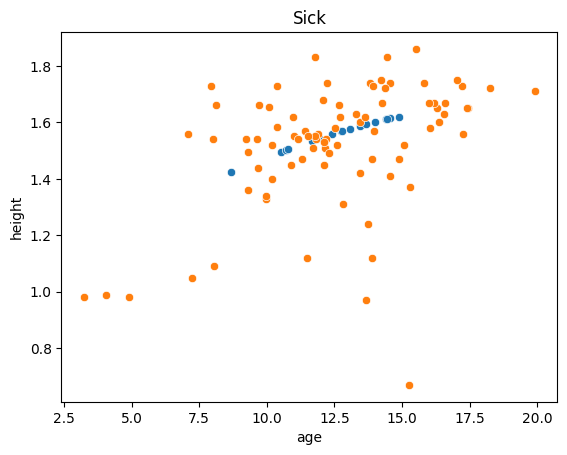

c:\Users\Z6JDB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\Z6JDB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\Z6JDB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\Z6JDB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\Z6JDB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, 

MAE: 0.06594416939872454
RMSE: 0.0755420826115383


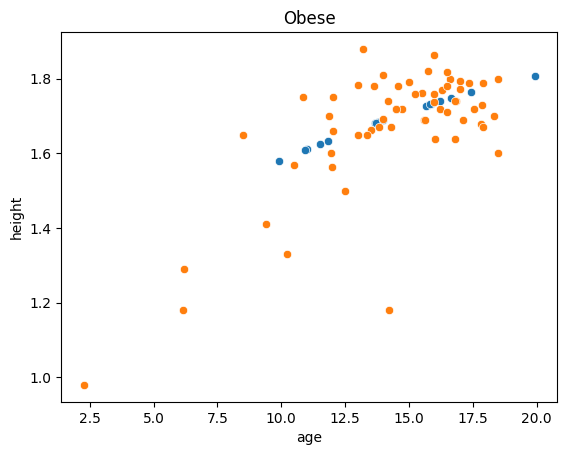

c:\Users\Z6JDB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\Z6JDB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\Z6JDB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\Z6JDB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\Z6JDB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, 

MAE: 0.07401255022167508
RMSE: 0.07593653592232645


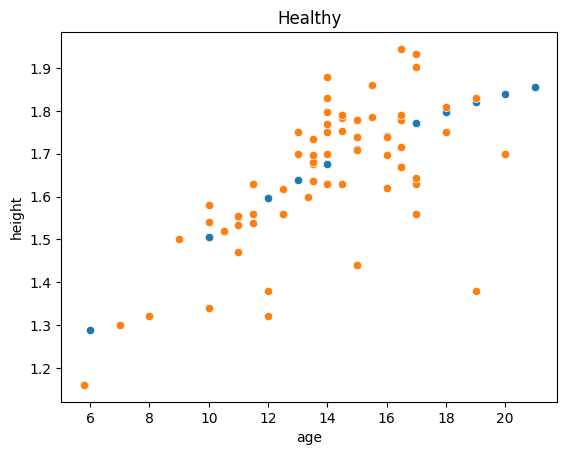

c:\Users\Z6JDB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\Z6JDB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\Z6JDB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\Z6JDB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\Z6JDB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, 

In [42]:
loop = 0 
for set in [sick, obese, healthy]:
    predict_height(set, loop, True)
    loop +=1

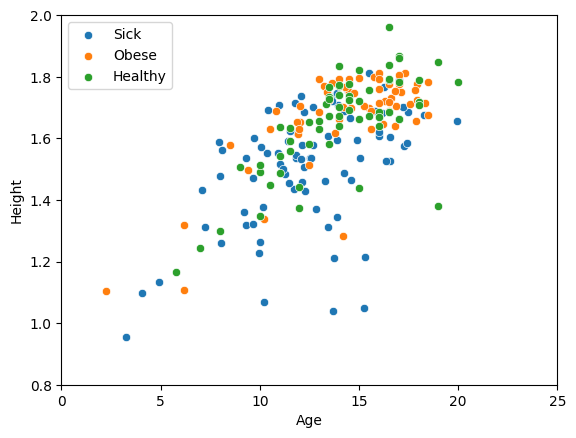

In [44]:

sns.scatterplot(data=sick, x = 'age', y='height', label= 'Sick')
sns.scatterplot(data=obese, x = 'age', y='height', label = 'Obese' )
sns.scatterplot(data=healthy, x = 'age', y='height', label = 'Healthy')
plt.xlabel('Age')
plt.ylabel('Height')
plt.ylim((0.8,2))
plt.xlim((0,25))
plt.legend(loc=2)